## 1. Data preparation

### Load the dataset

In [113]:
import pandas as pd
import numpy as np
from sklearn.metrics import mutual_info_score,accuracy_score,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split,KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,export_text
from collections import Counter
from tqdm.auto import tqdm
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [114]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [115]:
data = './diabetes_dataset.csv'

In [116]:
!head $data

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0
3,78,50,32,88,31,0.248,26,1
10,115,0,0,0,35.3,0.134,29,0
2,197,70,45,543,30.5,0.158,53,1


In [117]:
df = pd.read_csv(data)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 2. Exploratory Data Analysis (EDA)

### Display basic information about the dataset

In [118]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [120]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Check for missing values

In [121]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [122]:
numeric_columns = df._get_numeric_data()
object_columns = df.select_dtypes(include=['object'])
X = numeric_columns.drop('Outcome',axis = 1)
y = df[["Outcome"]]
y.columns,X.columns

(Index(['Outcome'], dtype='object'),
 Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
        'BMI', 'DiabetesPedigreeFunction', 'Age'],
       dtype='object'))

In [123]:
features = X.columns.to_list()
features

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

### Plot distributions for numerical columns

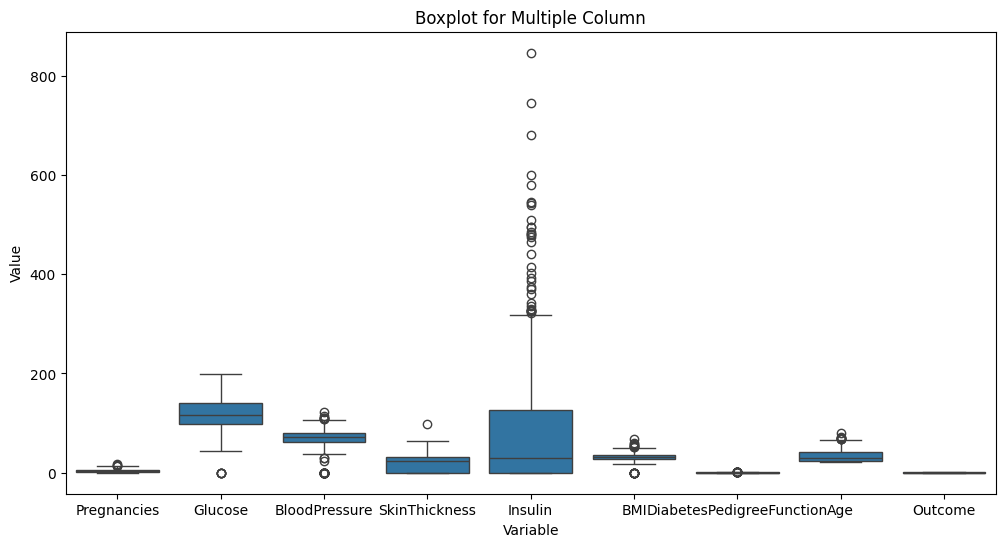

In [124]:
def showBoxplt(df):
    df_melted = df.melt(var_name='Variable', value_name='Value')
    # Create a boxplot with custom color
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Variable', y='Value', data=df_melted)  # Set2 is an example palette
    plt.title('Boxplot for Multiple Column')
    plt.show()
showBoxplt(df)

### Remove Outliers

In [125]:
def remove_outliers_iqr(df,column):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # Filtering out the rows that are outside of the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

# Remove outliers
df = remove_outliers_iqr(df,'Glucose')
df = remove_outliers_iqr(df,'BloodPressure')
df = remove_outliers_iqr(df,'SkinThickness')
df = remove_outliers_iqr(df,'Insulin')
df = remove_outliers_iqr(df,'BMI')
df = remove_outliers_iqr(df,'Age')

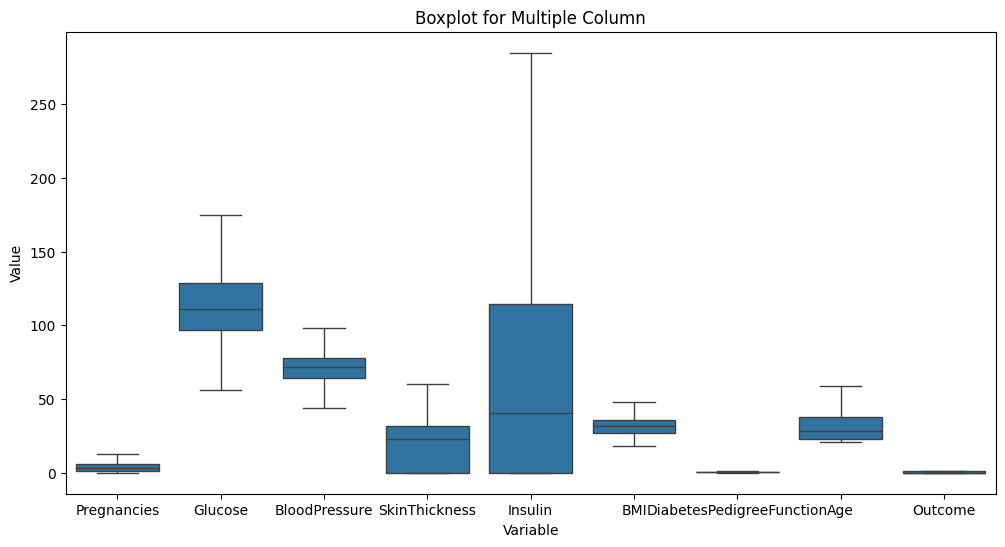

In [126]:
showBoxplt(df)

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 556 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               556 non-null    int64  
 1   Glucose                   556 non-null    int64  
 2   BloodPressure             556 non-null    int64  
 3   SkinThickness             556 non-null    int64  
 4   Insulin                   556 non-null    int64  
 5   BMI                       556 non-null    float64
 6   DiabetesPedigreeFunction  556 non-null    float64
 7   Age                       556 non-null    int64  
 8   Outcome                   556 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 43.4 KB


In [128]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000
mean,3.687050,114.052158,71.206835,20.492806,62.794964,31.617086,0.410581,31.167266,0.267986
std,3.220863,24.316438,10.645069,15.212310,73.911520,6.274195,0.226119,9.639020,0.443309
min,0.000000,56.000000,44.000000,0.000000,0.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,97.000000,64.000000,0.000000,0.000000,26.975000,0.237000,23.000000,0.000000
50%,3.000000,111.000000,72.000000,23.000000,40.500000,31.600000,0.349000,28.000000,0.000000
75%,6.000000,129.000000,78.000000,32.000000,114.250000,35.625000,0.557500,38.000000,1.000000
max,13.000000,175.000000,98.000000,60.000000,285.000000,48.300000,1.022000,59.000000,1.000000


### Correlation heatmap

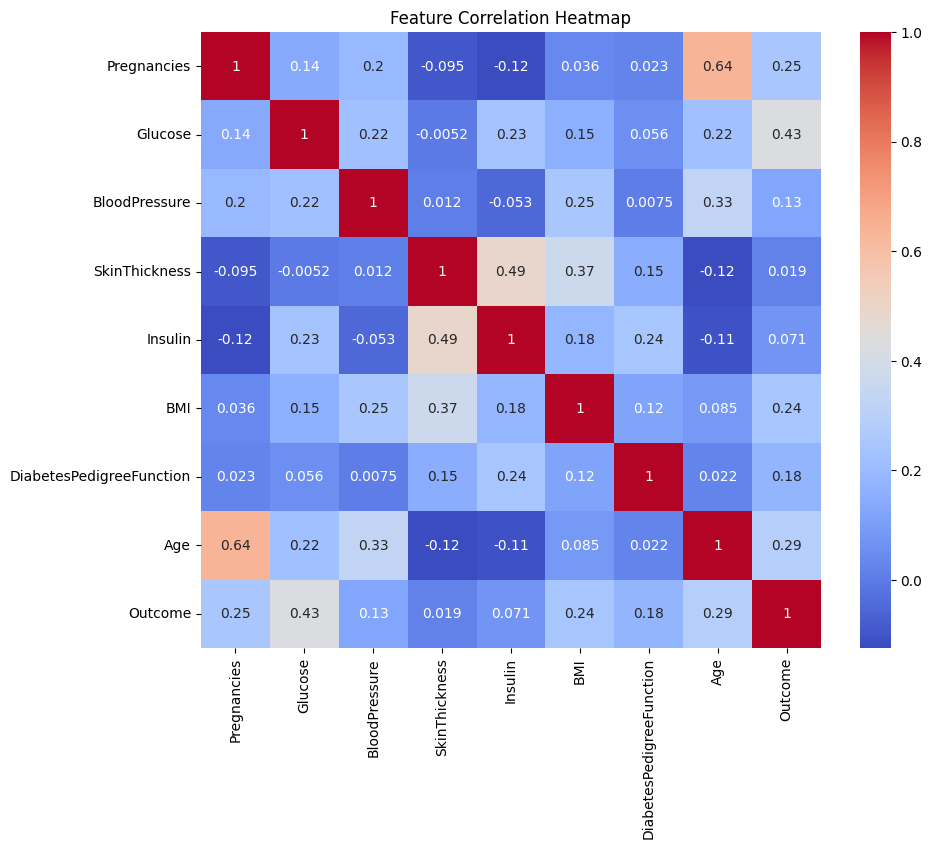

In [129]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [130]:
df.corr().unstack().sort_values(ascending=False).iloc[8:]

,,0
Outcome,Outcome,1.000000
Pregnancies,Age,0.639163
Age,Pregnancies,0.639163
Insulin,SkinThickness,0.486622
SkinThickness,Insulin,0.486622
...,...,...
Insulin,Age,-0.106722
Age,SkinThickness,-0.123725
SkinThickness,Age,-0.123725
Pregnancies,Insulin,-0.124026


In [131]:
df_target = df['Outcome']
total = df_target.count()
df_target.value_counts()/total

,count
Outcome,
0,0.732014
1,0.267986


### Feature Engineering

In [132]:
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 24.9, 29.9, np.inf],
                              labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Encode BMI_Category
data = pd.get_dummies(df, columns=['BMI_Category'], drop_first=True)

# Display the modified dataset
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Category_Normal,BMI_Category_Overweight,BMI_Category_Obese
0,6,148,72,35,0,33.6,0.627,50,1,False,False,True
1,1,85,66,29,0,26.6,0.351,31,0,False,True,False
3,1,89,66,23,94,28.1,0.167,21,0,False,True,False
5,5,116,74,0,0,25.6,0.201,30,0,False,True,False
6,3,78,50,32,88,31.0,0.248,26,1,False,False,True


### Split dataset to train and test

In [133]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome',
       'BMI_Category_Normal', 'BMI_Category_Overweight', 'BMI_Category_Obese'],
      dtype='object')

In [134]:
categorical = [
    'BMI_Category_Normal', 'BMI_Category_Overweight', 'BMI_Category_Obese'
]

In [135]:
numerical = data.columns.drop(categorical)
numerical = numerical.to_list()
numerical.remove('BMI')
numerical.remove('Outcome')
numerical

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'DiabetesPedigreeFunction',
 'Age']

In [136]:
data[categorical].head()

,BMI_Category_Normal,BMI_Category_Overweight,BMI_Category_Obese
0,False,False,True
1,False,True,False
3,False,True,False
5,False,True,False
6,False,False,True


In [137]:
global_obese = data.Outcome.mean()
global_obese

0.26798561151079137

In [138]:
def mutual_info_obese_score(series):
    return mutual_info_score(series, data.Outcome)

In [139]:
mi = data[categorical].apply(mutual_info_obese_score)
mi.sort_values(ascending=False)

,0
BMI_Category_Obese,0.028933
BMI_Category_Normal,0.028669
BMI_Category_Overweight,0.003492


In [140]:
data[numerical].corrwith(data.Outcome).abs()

,0
Pregnancies,0.248129
Glucose,0.429107
BloodPressure,0.125304
SkinThickness,0.018855
Insulin,0.070583
DiabetesPedigreeFunction,0.175675
Age,0.289717


In [141]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [142]:
def generate_data(data):
    df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
    df_train = df_full_train[categorical+numerical]
    df_val = df_test[categorical+numerical]
    y_train = df_full_train["Outcome"].values
    y_val = df_test["Outcome"].values
    del df_full_train["Outcome"]
    del df_test["Outcome"]
    return df_train, df_val, y_train, y_val

In [143]:
df_train, df_val, y_train, y_val = generate_data(data)

## 3. Model selection process and parameter tuning

### 3.1 LogisticRegression

In [144]:
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]
accuracy_score(y_val, y_pred >= 0.5)

0.8303571428571429

In [145]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=10000)
    model.fit(X_train, y_train)

    return dv, model

In [146]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [147]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    # print('%.2f %.3f' % (t, score))
    scores.append(score)

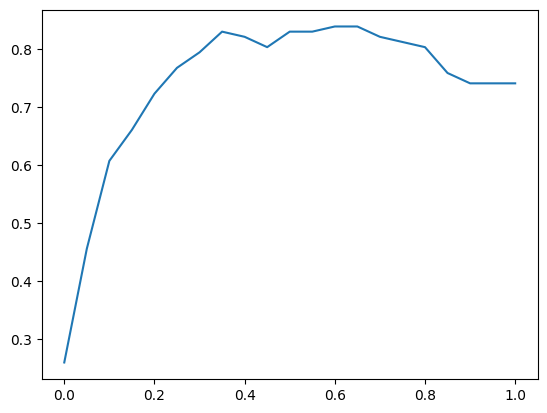

In [148]:
plt.plot(thresholds, scores)

In [149]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [150]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

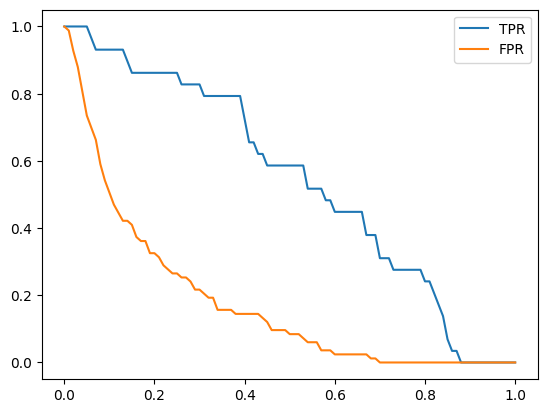

In [151]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

In [ ]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    # print('%.2f %.3f' % (t, score))
    scores.append(score)

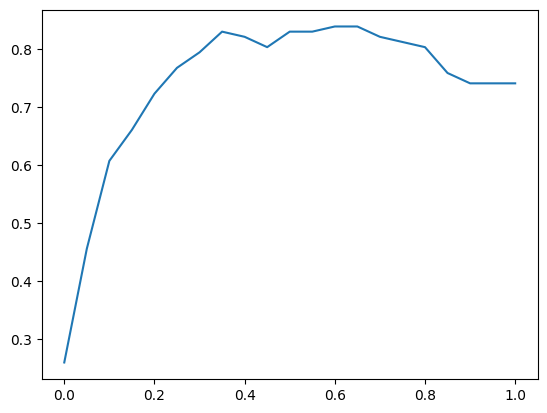

In [ ]:
plt.plot(thresholds, scores)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

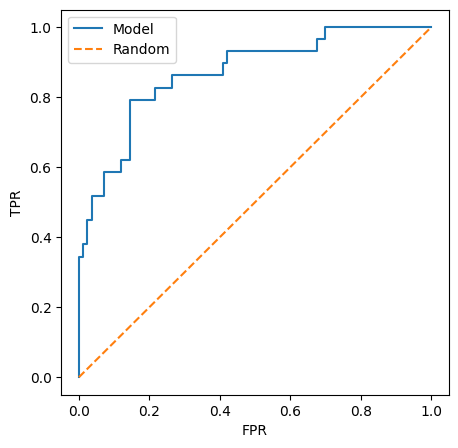

In [ ]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [ ]:
dv, model = train(df_train, y_train, C=0.001)

In [ ]:
y_pred = predict(df_val, dv, model)
accuracy_score(y_val, y_pred >= 0.5)

0.8303571428571429

In [ ]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(data):
        df_train = data.iloc[train_idx]
        df_val = data.iloc[val_idx]
        y_train = df_train.Outcome.values
        y_val = df_val.Outcome.values
        del df_train['Outcome']
        del df_val['Outcome']
        del df_train['BMI']
        del df_val['BMI']
        # print(df_train.columns)
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.796 +- 0.057
C=0.01 0.802 +- 0.065
C=0.1 0.821 +- 0.065
C=0.5 0.830 +- 0.065
C=1 0.832 +- 0.065
C=5 0.831 +- 0.066
C=10 0.830 +- 0.066


In [ ]:
df_train, df_val, y_train, y_val = generate_data(data)
dv, model = train(df_train, y_train, C=1)
y_pred = predict(df_val, dv, model)
auc = roc_auc_score(y_val, y_pred)
auc

0.8687162442874948

### Save the model

In [ ]:
def save_logistic_regression_model(dv, model, c):
    output_file = f'lr_model_C={c}.bin'
    return save_model(dv, model, output_file)
def save_model(dv, model, output_file):
    f_out = open(output_file, 'wb')
    pickle.dump((dv, model), f_out)
    f_out.close()
    return output_file

In [ ]:
C = 1
input_file = save_logistic_regression_model(dv, model, C)

In [ ]:
!ls -lh *.bin

-rw-r--r-- 1 root root 1.2K Nov 11 04:01 'lr_model_C=1.bin'


### Load the model

In [ ]:
input_file

'lr_model_C=1.bin'

In [ ]:
def load_model(input_file):
    with open(input_file, 'rb') as f_in:
        dv, model = pickle.load(f_in)
    return dv, model

In [ ]:
dv, model = load_model(input_file)
model

LogisticRegression(C=1, max_iter=10000)

In [ ]:
def predict_single(patient, dv, model):
    X = dv.transform([patient])
    y_pred = model.predict_proba(X)[0, 1]
    print('input:', patient)
    print('output:', y_pred)
    return y_pred

In [ ]:
p = data.iloc[0]

p1 = {"Pregnancies":1,"Glucose":85,"BloodPressure":66,"SkinThickness":29,"Insulin":0,"DiabetesPedigreeFunction":0.351,"Age":31,
      "BMI_Category_Normal":'false',
      "BMI_Category_Overweight":'true',
      "BMI_Category_Obese":'false'}
p2 = {"Pregnancies":6,"Glucose":148,"BloodPressure":72,"SkinThickness":35,"Insulin":0,"DiabetesPedigreeFunction":0.627,"Age":50,
      "BMI_Category_Normal":'false',
      "BMI_Category_Overweight":'false',
      "BMI_Category_Obese":'true'}
p.to_json()

'{"Pregnancies":6,"Glucose":148,"BloodPressure":72,"SkinThickness":35,"Insulin":0,"BMI":33.6,"DiabetesPedigreeFunction":0.627,"Age":50,"Outcome":1,"BMI_Category_Normal":false,"BMI_Category_Overweight":false,"BMI_Category_Obese":true}'

In [ ]:
predict_single(p1, dv, model)

input: {'Pregnancies': 1, 'Glucose': 85, 'BloodPressure': 66, 'SkinThickness': 29, 'Insulin': 0, 'DiabetesPedigreeFunction': 0.351, 'Age': 31, 'BMI_Category_Normal': 'false', 'BMI_Category_Overweight': 'true', 'BMI_Category_Obese': 'false'}
output: 0.03600963908376397


0.03600963908376397

In [ ]:
predict_single(p2, dv, model)

input: {'Pregnancies': 6, 'Glucose': 148, 'BloodPressure': 72, 'SkinThickness': 35, 'Insulin': 0, 'DiabetesPedigreeFunction': 0.627, 'Age': 50, 'BMI_Category_Normal': 'false', 'BMI_Category_Overweight': 'false', 'BMI_Category_Obese': 'true'}
output: 0.7085715555288974


0.7085715555288974

### 3.2 DecisionTreeClassifier

In [ ]:
df_train.columns

Index(['BMI_Category_Normal', 'BMI_Category_Overweight', 'BMI_Category_Obese',
       'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [ ]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train.fillna(0).to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 1.0
val: 0.6510178645616951


In [ ]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- Glucose <= 139.50
|   |--- Age <= 28.50
|   |   |--- DiabetesPedigreeFunction <= 0.50
|   |   |   |--- Glucose <= 111.50
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.13
|   |   |   |   |   |--- Insulin <= 110.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Insulin >  110.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- DiabetesPedigreeFunction >  0.13
|   |   |   |   |   |--- class: 0
|   |   |   |--- Glucose >  111.50
|   |   |   |   |--- BloodPressure <= 77.00
|   |   |   |   |   |--- Insulin <= 230.00
|   |   |   |   |   |   |--- DiabetesPedigreeFunction <= 0.28
|   |   |   |   |   |   |   |--- DiabetesPedigreeFunction <= 0.27
|   |   |   |   |   |   |   |   |--- Age <= 24.50
|   |   |   |   |   |   |   |   |   |--- SkinThickness <= 39.00
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- SkinThickness >  39.00
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |-

In [ ]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, 40, None]

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.623
   2 -> 0.730
   3 -> 0.739
   4 -> 0.773
   5 -> 0.747
   6 -> 0.769
  10 -> 0.703
  15 -> 0.640
  20 -> 0.685
  40 -> 0.645
None -> 0.598


In [ ]:
scores = []
for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((depth, s, auc))

In [ ]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [ ]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.751  0.714
5                 0.773  0.751  0.734
10                0.778  0.780  0.756
15                0.765  0.799  0.763
20                0.773  0.770  0.777
100               0.778  0.778  0.778
200               0.726  0.726  0.726
500               0.500  0.500  0.500

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

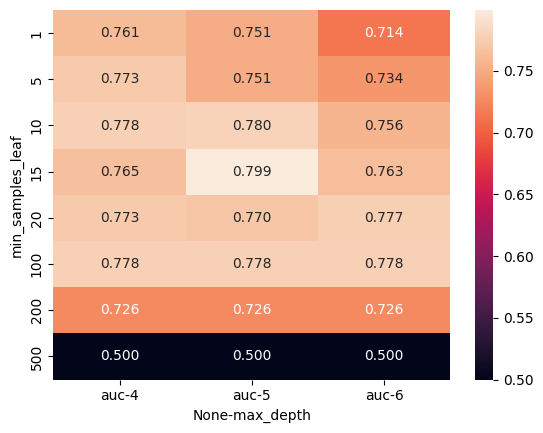

In [ ]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [ ]:
max_depth=5
min_samples_leaf=15
dv = DictVectorizer(sparse=False)
train_dicts = df_train.fillna(0).to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)
dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=15)

In [ ]:
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
auc

0.7993352721229747

In [ ]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- Glucose <= 139.50
|   |--- Age <= 28.50
|   |   |--- DiabetesPedigreeFunction <= 0.50
|   |   |   |--- Glucose <= 111.50
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.17
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- DiabetesPedigreeFunction >  0.17
|   |   |   |   |   |--- class: 0
|   |   |   |--- Glucose >  111.50
|   |   |   |   |--- SkinThickness <= 28.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- SkinThickness >  28.00
|   |   |   |   |   |--- class: 0
|   |   |--- DiabetesPedigreeFunction >  0.50
|   |   |   |--- SkinThickness <= 33.50
|   |   |   |   |--- BloodPressure <= 61.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- BloodPressure >  61.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- SkinThickness >  33.50
|   |   |   |   |--- class: 0
|   |--- Age >  28.50
|   |   |--- Glucose <= 89.50
|   |   |   |--- class: 0
|   |   |--- Glucose >  89.50
|   |   |   |--- BMI_Category_Normal <= 0.50
|   |   |   |   |--- DiabetesPedigreeFunct

In [ ]:
def save_decisionTreeClassifier_model(dv, dt, max_depth=5,min_samples_leaf=15):
    output_file = f'dtc_model_max_depth={max_depth}_min_samples_leaf={min_samples_leaf}.bin'
    return save_model(dv, dt, output_file)

In [ ]:
input_file = save_decisionTreeClassifier_model(dv,dt)
input_file

'dtc_model_max_depth=5_min_samples_leaf=15.bin'

In [ ]:
dv, dt = load_model(input_file)
dt

DecisionTreeClassifier(max_depth=5, min_samples_leaf=15)

In [ ]:
predict_single(p1,dv, dt)

input: {'Pregnancies': 1, 'Glucose': 85, 'BloodPressure': 66, 'SkinThickness': 29, 'Insulin': 0, 'DiabetesPedigreeFunction': 0.351, 'Age': 31, 'BMI_Category_Normal': 'false', 'BMI_Category_Overweight': 'true', 'BMI_Category_Obese': 'false'}
output: 0.038461538461538464


0.038461538461538464

In [ ]:
predict_single(p2,dv, dt)

input: {'Pregnancies': 6, 'Glucose': 148, 'BloodPressure': 72, 'SkinThickness': 35, 'Insulin': 0, 'DiabetesPedigreeFunction': 0.627, 'Age': 50, 'BMI_Category_Normal': 'false', 'BMI_Category_Overweight': 'false', 'BMI_Category_Obese': 'true'}
output: 0.8846153846153846


0.8846153846153846

### 3.3 RandomForestClassifier

In [ ]:
df_train, df_val, y_train, y_val = generate_data(data)
dv = DictVectorizer(sparse=False)
train_dicts = df_train.fillna(0).to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [ ]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    scores.append((n, auc))

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

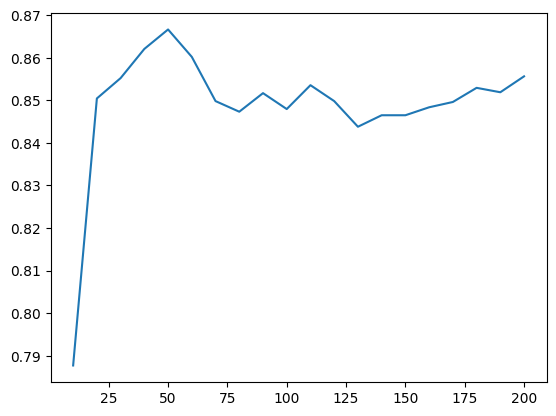

In [ ]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [ ]:
scores = []

for d in tqdm([5, 10, 15]):
    for n in tqdm(range(10, 201, 10)):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/3 [00:00<?, ?it/s]

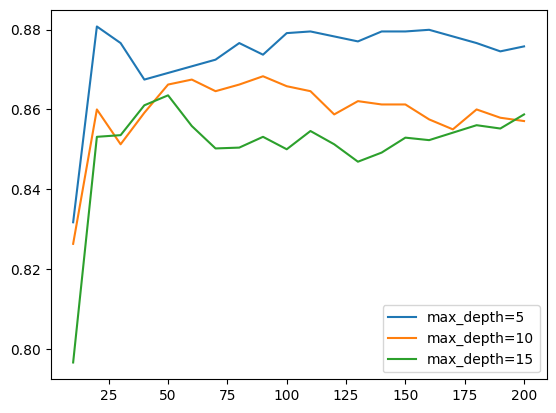

In [ ]:
for d in tqdm([5, 10, 15]):
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [ ]:
max_depth = 5

In [ ]:
scores = []

for s in tqdm([1, 3, 5, 10, 50]):
    for n in tqdm(range(10, 201, 10)):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

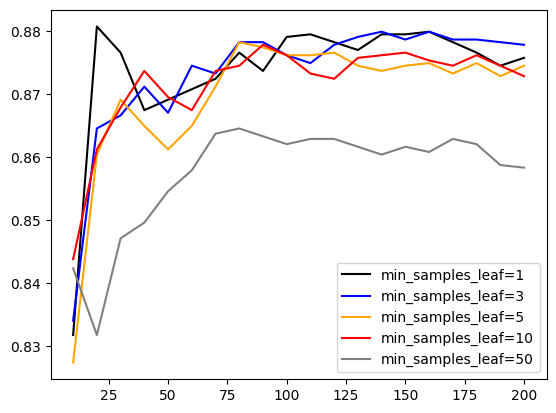

In [ ]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]

    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [ ]:
min_samples_leaf = 1

In [ ]:
def auc_RandomForestClassifier(n_estimators):
  rf = RandomForestClassifier(n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
  rf.fit(X_train, y_train)
  y_pred = rf.predict_proba(X_val)[:, 1]
  auc = roc_auc_score(y_val, y_pred)
  print(auc)
  return rf

In [ ]:
auc_RandomForestClassifier(200)

0.8757789779808891


RandomForestClassifier(max_depth=5, n_estimators=200, random_state=1)

In [ ]:
rf = auc_RandomForestClassifier(20)
rf

0.8807644370585791


RandomForestClassifier(max_depth=5, n_estimators=20, random_state=1)

In [ ]:
def save_RandomForestClassifier(dv, rf, n_estimators=20,max_depth=5,min_samples_leaf=1):
    output_file = f'rfc_model_n_estimators={max_depth}_max_depth={max_depth}_min_samples_leaf={min_samples_leaf}.bin'
    return save_model(dv, rf, output_file)

In [ ]:
input_file = save_RandomForestClassifier(dv, rf)
input_file

'rfc_model_n_estimators=5_max_depth=5_min_samples_leaf=1.bin'

In [ ]:
dv, rf = load_model(input_file)
rf

RandomForestClassifier(max_depth=5, n_estimators=20, random_state=1)

In [ ]:
predict_single(p1,dv, rf)

input: {'Pregnancies': 1, 'Glucose': 85, 'BloodPressure': 66, 'SkinThickness': 29, 'Insulin': 0, 'DiabetesPedigreeFunction': 0.351, 'Age': 31, 'BMI_Category_Normal': 'false', 'BMI_Category_Overweight': 'true', 'BMI_Category_Obese': 'false'}
output: 0.09850037781358287


0.09850037781358287

In [ ]:
predict_single(p2,dv, dt)

input: {'Pregnancies': 6, 'Glucose': 148, 'BloodPressure': 72, 'SkinThickness': 35, 'Insulin': 0, 'DiabetesPedigreeFunction': 0.627, 'Age': 50, 'BMI_Category_Normal': 'false', 'BMI_Category_Overweight': 'false', 'BMI_Category_Obese': 'true'}
output: 0.8846153846153846


0.8846153846153846

### 3.4 Selecting the final model: RandomForestClassifier(max_depth=5, n_estimators=20, random_state=1)